In [36]:
%matplotlib notebook
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
import time
import plotly.express as px

In [38]:
class Configuration:
    """A configuration of Ising spins"""
    def __init__(self, T, J, L):
        self.size = L    # Size of the lattice
        self.J = J    # exchange interaction coefficient
        self.beta = 1./T    # inverse temperature
        self.spins = rnd.choice([-1,1], size=(L,L))    # either +1 or -1 (charge deviation)
        self.magnetization = self._get_magnetization()    # magnetization of the system (total electric charge)
        self._zero_magnetization()    # setting the total magnetization (electric charge) to zero
        self.energy = self._get_energy()    # total energy of the system
#         self.total_magnetization = self.spins    # should be updated every cycle
#         self.total_chi = np.zeros((L,L))
#         self.total_spins = np.zeros((L,L))
        self.Nq = int(self.size * 1.125) + 1    # size of the partition of q
        self.q_range = 3 * np.pi
        self.q = np.linspace(-self.q_range / 2, self.q_range / 2, self.Nq)
        self.chi_paral = np.zeros((self.Nq, self.Nq))
        self.chi_paral_total = np.zeros((self.Nq, self.Nq))
        self.number_of_cycles = 0
#         self.avg_magnetization = self.total_magnetization / self.number_of_cycles    # should be updated every cycle
        self.chi = np.zeros((L,L), dtype = 'float64')
        self.avg_spins = np.zeros((L,L), dtype = 'float64')
    
    def _zero_magnetization(self):
        """Sets the magnetization of the system to zero"""
        L = self.size
#         print(self.magnetization)
        while self.magnetization > 0:
            i, j = rnd.randint(L), rnd.randint(L)
            if self.spins[i,j] > 0:
                self.spins[i,j] *= -1
                self.magnetization -= 2
        while self.magnetization < 0:
            i, j = rnd.randint(L), rnd.randint(L)
            if self.spins[i,j] < 0:
                self.spins[i,j] *= -1
                self.magnetization += 2
    def get_spins(self):
        return self.spins
        
    def _get_energy(self):
        """Returns the total energy"""
        energ = 0.
        L = self.size
        for i,j in itertools.product(range(self.size), repeat=2):
            energ += self.J[0] * self.spins[i,j] * (self.spins[(i + 1) % L, j] + \
                                                    self.spins[i ,(j + 1) % L] + \
                                                    self.spins[(i + 1) % L, (j + 1) % L])
            energ += self.J[1] * self.spins[i,j] * (self.spins[(i + 1) % L, (j - 1) % L] + \
                                                     self.spins[(i + 2) % L, (j + 1) % L] + \
                                                     self.spins[(i + 1)% L ,(j + 2) % L])
            energ += self.J[2] * self.spins[i,j] * (self.spins[(i + 2) % L, j] + \
                                                     self.spins[(i + 2) % L, (j + 2) % L] + \
                                                     self.spins[i ,(j + 2) % L])
        return energ
    
    def _get_magnetization(self):
        """Returns the total magnetization"""
        magnet = np.sum(self.spins)
        return magnet
    
    def update_chi_paral(self):
        """Updates the matrix self.chi_paral_total and
        increases self.number_of_cycles by one"""
        Nq = self.Nq
        q = self.q
        print(q)
        L = self.size
        chi = 0
        for i in range(Nq):
            for j in range(Nq):
                for k in range(L):
                    for l in range(L):
                        r_i = self.position(k,l)
                        q_i = np.array((q[i], q[j]))
                        chi += self.spins[k, l] * np.exp(-1j * np.dot(q_i, r_i))
#                         print(chi, i, j, q_i, r_i)
                self.chi_paral_total[i,j] += chi * np.conj(chi)
                chi = 0
        self.number_of_cycles += 1
        self.chi_paral = self.chi_paral_total / (self.number_of_cycles * self.size ** 2)
    
    def position(self, i, j):
        """Returns the postion in real space of the lattice point i,j"""
        return np.array((i - 0.5 * j, np.sqrt(3) / 2 * j))
#         return np.array((i - 0.5 * j, np.sqrt(3) / 2 * j)) * 1e-9
        
#     def chi_momentum(self, q):
#         """Return the susceptibility in the momentum space"""
#         L = self.size
#         central = np.array((L // 2, L // 2))
# #         pos_central = self.pos(central[0], central[1])
#         momentum = 0
#         for i in range(L):
#             for j in range(L):
# #                 r = self.pos(i, j) - pos_central
# #                 r = self.position(i - central[0], j - central[1])
# #                 r = self.position(i, j) - self.position(central[0], central[1])
#                 r = self.position(i, j) - self.position(central[0], central[1])
# #                 momentum += np.exp(-1j * np.sum(np.dot(q, r))) * self.chi_real((i, j))
# #                 momentum += np.exp(-1j * np.sum(np.dot(q, r))) * self.chi[i, j]
#                 momentum += np.exp(-1j * (q[0] * r[0] + q[1] * r[1])) * self.chi[i, j]
# #                 momentum += np.exp(-1j * np.dot(q, r)) * self.chi[i, j]
#         return momentum
    
def config_to_image(config):
    """Turn an array into an image"""
    L = config.size
    im = np.zeros([L,L,3])
    for i,j in itertools.product(range(L), repeat=2):
        im[i,j,:] = (1,0,0) if config.spins[i,j]==1 else (0,0,0)
    return im

def config_to_image_paral(config):
    """Turn an array into an image for triangular lattice
    in parallelogram shape"""
    L = config.size
    im = np.zeros([L,2 * L,3])
    for i,j in itertools.product(range(L), repeat=2):
#         im[i,j+L//2-i//2,:] = (1,0,0) if config.spins[i,j]==1 else (0,0,0)
        im[i,j - i + L - 1,:] = (1,0,0) if config.spins[i,j]==1 else (0,0,0)
    return im

def plot_real_space(a, s = 7):
    """Plots the array a in a read space"""
    for i in range(len(a)):
        delta_x = (len(a) - i - 1) / 2
        x = np.arange(delta_x, len(a) + delta_x, dtype = np.float64)
        if x[-1] == len(a) + delta_x: x = x[0:-1]
        y1 = np.zeros(len(a)) + (len(a) - i - 1) * np.sqrt(3) / 2
        y2 = np.zeros(len(a)) + (len(a) - i - 1) * np.sqrt(3) / 2
        for j in range(len(a[i])):
            if a[i][j] == 1:
                y1[j] = np.nan
            else:
                y2[j] = np.nan
        plt.plot(x, y1, '.', color = "black", markersize = s)
        plt.plot(x, y2, '.', color = "red", markersize = s)
    plt.xlim(-1,len(a) * 3 / 2 + 1)
    plt.ylim(-1,len(a) * 3 / 2 + 1)
    plt.axis('equal')
    plt.title('Electronic distribution in real space')
    plt.ylabel('Position y-axis')
    plt.xlabel('Position x-axis')
#     plt.ylim(-1,len(a) * np.sqrt(3) / 2)
    plt.show()

In [39]:
def metropolis_move(config):
    """Modify (or not) a configuration with Metropolis algorithm"""
    
    L = config.size
    J1 = config.J[0]
    J2 = config.J[1]
    J3 = config.J[2]
    beta = config.beta
    i1, j1 = rnd.randint(L, size=(2)) # pick a random site
    i2, j2 = rnd.randint(L, size=(2))
    while config.spins[i1,j1] == config.spins[i2,j2]:
        i2, j2 = rnd.randint(L, size=(2))
    
    # compute energy difference
    coef11 = -2 * J1 * config.spins[i1,j1]
    coef21 = -2 * J2 * config.spins[i1,j1]
    coef31 = -2 * J3 * config.spins[i1,j1]
    coef12 = -2 * J1 * config.spins[i2,j2]
    coef22 = -2 * J2 * config.spins[i2,j2]
    coef32 = -2 * J3 * config.spins[i2,j2]
    delta_energy = 0
    # changing the energy if one spin is flipped
    delta_energy += coef11 * (config.spins[i1,(j1 + 1) % L] + config.spins[(i1 + 1) % L, j1] + \
                           config.spins[i1,(j1 - 1) % L] + config.spins[(i1 - 1) % L, j1] + \
                           config.spins[(i1 + 1) % L, (j1 + 1) % L] + config.spins[(i1 - 1) % L, (j1 - 1) % L])
    
    delta_energy += coef21 * (config.spins[(i1 + 1) % L,(j1 - 1) % L] + config.spins[(i1 + 2) % L, (j1 + 1) % L] + \
                           config.spins[(i1 + 1) % L,(j1 + 2) % L] + config.spins[(i1 - 1) % L, (j1 + 1) % L] + \
                           config.spins[(i1 - 2) % L, (j1 - 1) % L] + config.spins[(i1 - 1) % L, (j1 - 2) % L])
    
    delta_energy += coef31 * (config.spins[i1,(j1 + 2) % L] + config.spins[(i1 + 2) % L, j1] + \
                           config.spins[i1,(j1 - 2) % L] + config.spins[(i1 - 2) % L, j1] + \
                           config.spins[(i1 + 2) % L, (j1 + 2) % L] + config.spins[(i1 - 2) % L, (j1 - 2) % L])
    config.spins[i1, j1] *= -1 # flipping the spin
    # changing the energy if the other spin is flipped
    delta_energy += coef12 * (config.spins[i2,(j2 + 1) % L] + config.spins[(i2 + 1) % L, j2] + \
                           config.spins[i2,(j2 - 1) % L] + config.spins[(i2 - 1) % L, j2] + \
                           config.spins[(i2 + 1) % L, (j2 + 1) % L] + config.spins[(i2 - 1) % L, (j2 - 1) % L])
    
    delta_energy += coef22 * (config.spins[(i2 + 1) % L,(j2 - 1) % L] + config.spins[(i2 + 2) % L, (j2 + 1) % L] + \
                           config.spins[(i2 + 1) % L,(j2 + 2) % L] + config.spins[(i2 - 1) % L, (j2 + 1) % L] + \
                           config.spins[(i2 - 2) % L, (j2 - 1) % L] + config.spins[(i2 - 1) % L, (j2 - 2) % L])
    
    delta_energy += coef32 * (config.spins[i2,(j2 + 2) % L] + config.spins[(i2 + 2) % L, j2] + \
                           config.spins[i2,(j2 - 2) % L] + config.spins[(i2 - 2) % L, j2] + \
                           config.spins[(i2 + 2) % L, (j2 + 2) % L] + config.spins[(i2 - 2) % L, (j2 - 2) % L])
    config.spins[i1, j1] *= -1 # flipping back the spin
    
    
    # accept modification with Metropolis probability
    # if not accepted: leave configuration unchanged
    if rnd.random() < np.exp(-beta*delta_energy):
        config.spins[i1,j1] *= -1
        config.spins[i2,j2] *= -1
        config.energy += delta_energy
        config.magnetization += 2*config.spins[i1,j1]
        config.magnetization += 2*config.spins[i2,j2]

def global_update(config):
    """Does a global update every cycle"""
    L = config.size
    for i in range(L):
        for j in range(L):
            config.spins[i,j] *= -1
    config.magnetization *= -1
    config.energy *= -1

In [40]:
# make sure susceptibility converges
L = 21
T = 0.2
length_cycle = L*L
nt = 20
J = np.ndarray(3)
J[0], J[1], J[2] = 1, -0.63, 0
central = L // 2, L // 2

# instantiate a configuration
config = Configuration(T, J, L)

print(config.position(5,6))

[2.         5.19615242]


In [68]:
# make sure susceptibility converges
L = 21
T = 0.2
length_cycle = L*L
nt = 20
J = np.ndarray(3)
J[0], J[1], J[2] = 1, 0, 0
central = L // 2, L // 2

# instantiate a configuration
config = Configuration(T, J, L)

# warmup with cooling
N_warmup = 100
T_old = T
for T1 in np.linspace(2, T_old, 5):
    T = T1
    for l in range(N_warmup):
        for k in range(length_cycle):
            metropolis_move(config)
    print(T)
print('Warmup done')
        
N_cycle = 100

for l in range(N_cycle):
    for k in range(length_cycle):
            metropolis_move(config)
    config.update_chi_paral()
    print(l)

2.0
1.55
1.1
0.6499999999999999
0.2
Warmup done
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]


<ipython-input-38-9901e9372d1b>:78: ComplexWarning:

Casting complex values to real discards the imaginary part



0
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
1
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
2
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
3
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.

28
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
29
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
30
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
31
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534

56
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
57
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
58
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
59
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534

84
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
85
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
86
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534 -1.02443239 -0.61465943 -0.20488648
  0.20488648  0.61465943  1.02443239  1.43420534  1.8439783   2.25375125
  2.66352421  3.07329716  3.48307012  3.89284307  4.30261603  4.71238898]
87
[-4.71238898 -4.30261603 -3.89284307 -3.48307012 -3.07329716 -2.66352421
 -2.25375125 -1.8439783  -1.43420534

<IPython.core.display.Javascript object>


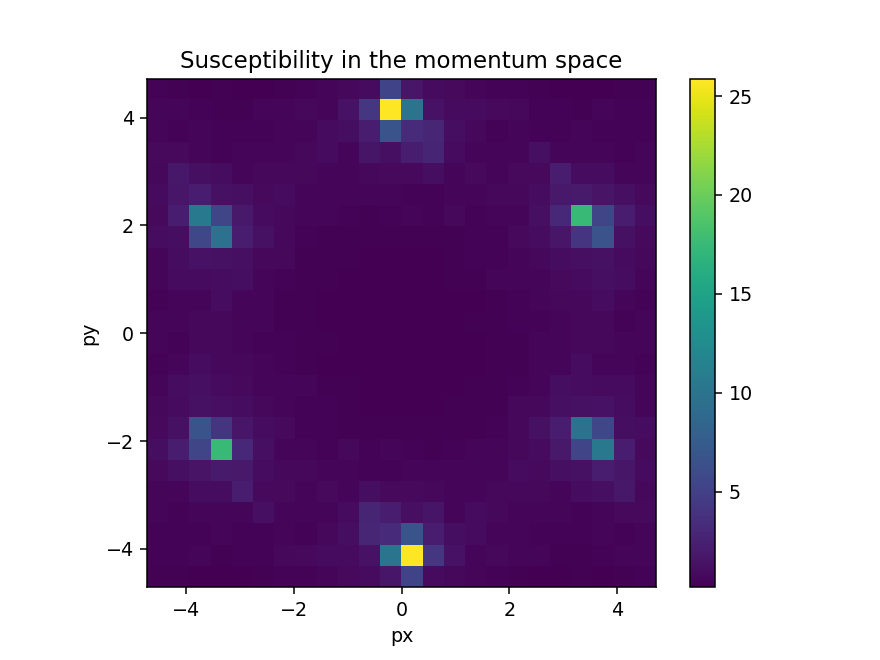

Text(0.5, 1.0, 'Susceptibility in the momentum space')

In [69]:
# px.imshow(config.chi_paral)
plt.imshow(config.chi_paral, extent=[-3/2*np.pi,3/2*np.pi,-3/2*np.pi,3/2*np.pi])
plt.colorbar()
plt.xlabel('px')
plt.ylabel('py')
plt.title('Susceptibility in the momentum space')

<IPython.core.display.Javascript object>


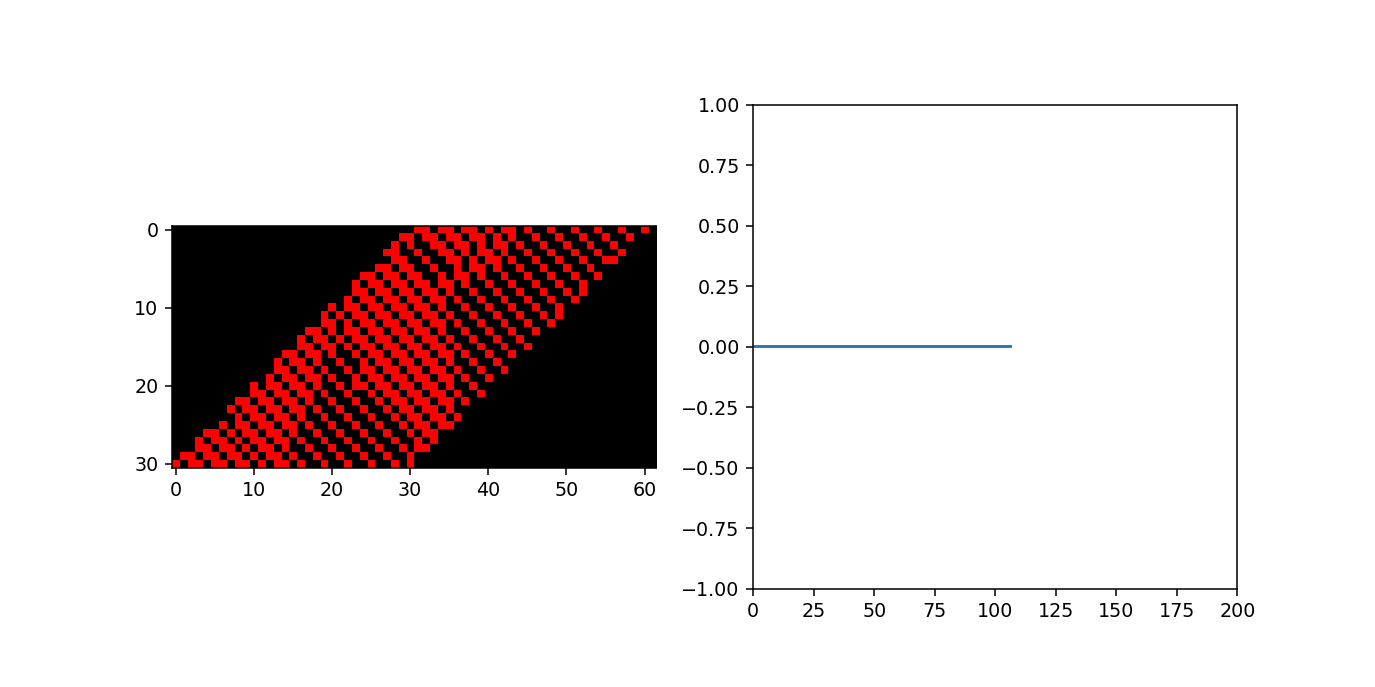

In [46]:
# make sure susceptibility converges
L = 31
T = 0.2
length_cycle = L*L
nt = 200
J = np.ndarray(3)
J[0], J[1], J[2] = 1, -1.5, 0
central = L // 2, L // 2

# instantiate a configuration
config = Configuration(T, J, L)

# a two-panel figure
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
im = ax1.imshow(config_to_image_paral(config), interpolation='none')
ax2 = fig.add_subplot(122, aspect=100)
line, = ax2.plot([],[])
ax2.set_xlim(0,nt)
ax2.set_ylim(-1,1)

steps = []
magnet = []

total_magnetization = np.zeros((L,L), dtype = 'float64')

def do_mc_cycle(n):
    for k in range(length_cycle):
        metropolis_move(config)
#     global_update(config)
    m = config.magnetization/float(config.size**2)
    im.set_array(config_to_image_paral(config))
    if len(steps) < nt: steps.append(n)
    if len(magnet) < nt:
        magnet.append(m)
    else:
        magnet.insert(nt, m)
        magnet.pop(0)

    line.set_data(steps, magnet)
    config.update_chi_paral()
#     average_magnetization = total_magnetization / config.number_of_cycles
#     config.avg_spins = config.total_spins / config.number_of_cycles
    return (im, line)

ani = animation.FuncAnimation(fig, do_mc_cycle, interval=1, blit=False)

In [47]:
px.imshow(config.chi_paral)

In [ ]:
config.number_of_cycles

In [ ]:
plot_real_space(config.spins, 19.5)